In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# Retrieve best device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
# Global constants to the problem.
UPSCALE_FACTOR = 2
INPUT_SIZE = 32
OUTPUT_SIZE = INPUT_SIZE * UPSCALE_FACTOR

In [25]:
# Defining the dataset.

from torchvision.datasets import Imagenette
import os.path
download = not os.path.exists('./data/imagenette2-160')
imagenette = Imagenette(root='./data', size="160px", split='train', download=download)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, in_lr_space: bool = False):
        super().__init__()
        self.data = imagenette

        if in_lr_space:
          self.input_transform = v2.Compose([
              v2.CenterCrop(OUTPUT_SIZE),
              v2.Resize(INPUT_SIZE),
              v2.ToImage(),
              v2.ToDtype(torch.float32, scale=True),
          ])
        else:
          self.input_transform = v2.Compose([
              v2.CenterCrop(OUTPUT_SIZE),
              v2.Resize(INPUT_SIZE),
              v2.Resize(OUTPUT_SIZE),
              v2.ToImage(),
              v2.ToDtype(torch.float32, scale=True),
          ])

        self.target_transform = v2.Compose([
            v2.CenterCrop(OUTPUT_SIZE),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, _ = self.data[idx]

        input = self.input_transform(img)
        target = self.target_transform(img)

        return input, target

hr_dataset = Dataset(in_lr_space=False)
lr_dataset = Dataset(in_lr_space=True)

n_train = int(len(hr_dataset) * 0.8)
n_test = len(hr_dataset) - n_train
print(f"Number of training samples: {n_train}")
print(f"Number of testing samples: {n_test}")

hr_dataset_train, hr_dataset_test = torch.utils.data.random_split(hr_dataset, [n_train, n_test])
lr_dataset_train, lr_dataset_test = torch.utils.data.random_split(lr_dataset, [n_train, n_test])

BATCH_SIZE = 16
hr_dataloader_train = torch.utils.data.DataLoader(hr_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
hr_dataloader_test = torch.utils.data.DataLoader(hr_dataset_test, batch_size=BATCH_SIZE, shuffle=True)
lr_dataloader_train = torch.utils.data.DataLoader(lr_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
lr_dataloader_test = torch.utils.data.DataLoader(lr_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

Number of training samples: 7575
Number of testing samples: 1894


Input shape: torch.Size([3, 64, 64])
Target shape: torch.Size([3, 64, 64])


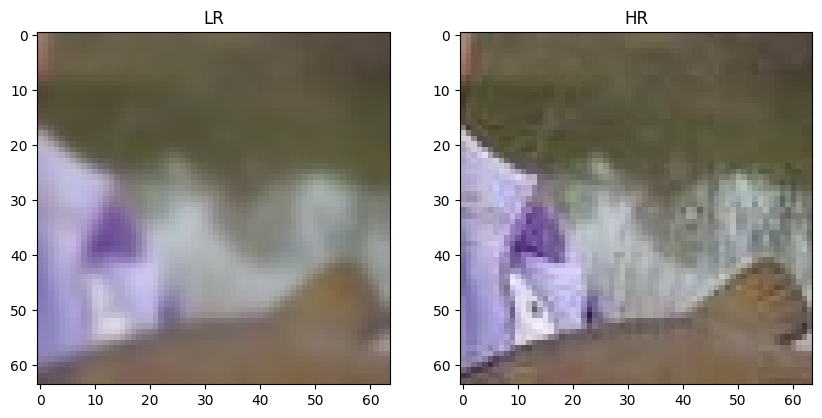

In [26]:
# Preview HR dataset

print("Input shape:", hr_dataset_train[0][0].shape)
print("Target shape:", hr_dataset_train[0][1].shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('LR')
plt.imshow(hr_dataset_train[0][0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('HR')
plt.imshow(hr_dataset_train[0][1].permute(1, 2, 0))

Input shape: torch.Size([3, 32, 32])
Target shape: torch.Size([3, 64, 64])


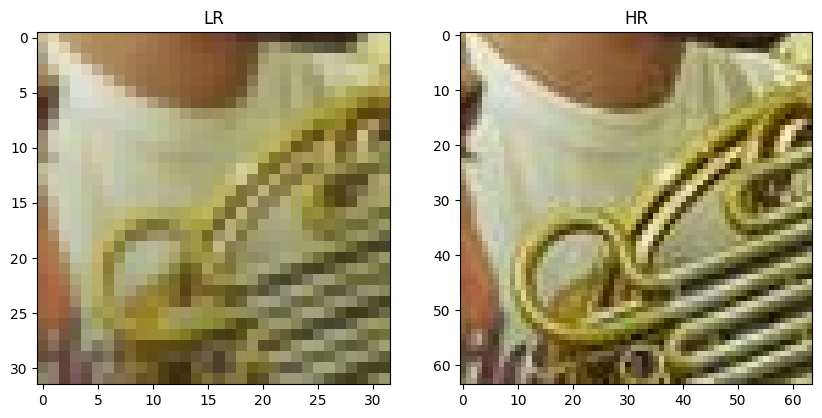

In [27]:
# Preview LR dataset

print("Input shape:", lr_dataset_train[0][0].shape)
print("Target shape:", lr_dataset_train[0][1].shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('LR')
plt.imshow(lr_dataset_train[0][0].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.title('HR')
plt.imshow(lr_dataset_train[0][1].permute(1, 2, 0))

In [40]:
def train_epoch(epoch, model, dataloader, optimizer, criterion):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader, 1):
        input, target = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()
        loss = criterion(model(input), target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        # print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("[TRAIN epoch {}] Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

def train_model(model, dataloader, epochs):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.MSELoss()
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

  for epoch in range(epochs):
    train_epoch(epoch, model, dataloader, optimizer, criterion)
    # scheduler.step()

## Super-resolution on high-resolution (HR) space

The idea, is to upscale a low-resolution image with a naive filter like a bicubic filter (this is the same as when resizing the image with any image editor or when zooming in a program). Then using a CNN to improve the resulting upscaled image to obtain super-resolution.

In [31]:
class HRNet(nn.Module):
    def __init__(self):
        super(HRNet, self).__init__()

        self.relu = nn.ReLU()
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        # Intermediate convolutions
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        # Output convolution
        self.conv4 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.conv4(x)
        return x
hr_model = HRNet()
hr_model

HRNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [32]:
train_model(hr_model, hr_dataloader_train, 10)

[TRAIN epoch 0] Loss: 0.0893
[TRAIN epoch 1] Loss: 0.0113
[TRAIN epoch 2] Loss: 0.0111
[TRAIN epoch 3] Loss: 0.0108
[TRAIN epoch 4] Loss: 0.0107
[TRAIN epoch 5] Loss: 0.0107
[TRAIN epoch 6] Loss: 0.0107
[TRAIN epoch 7] Loss: 0.0106
[TRAIN epoch 8] Loss: 0.0105
[TRAIN epoch 9] Loss: 0.0105


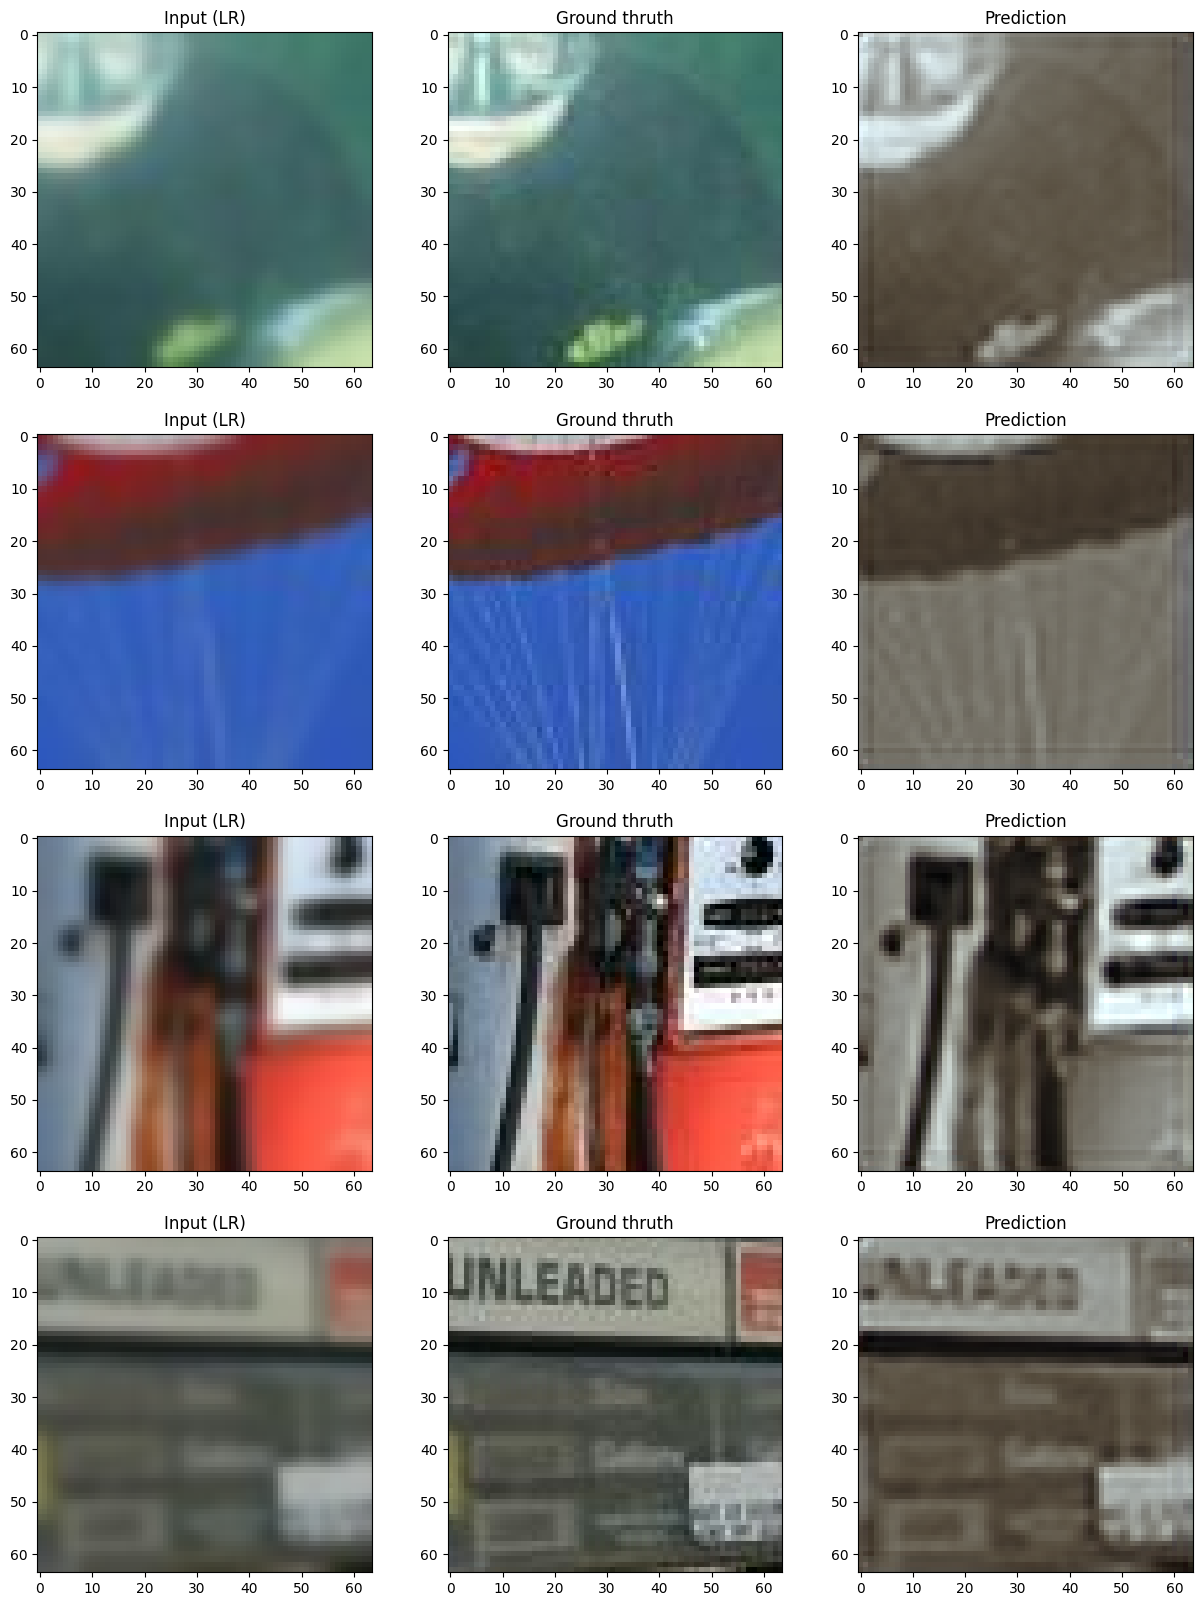

In [41]:
examples_count = 4

plt.figure(figsize=(15, 5 * examples_count))

for i in range(examples_count):
  input, output = hr_dataset_test[i]
  output_pred = hr_model(input.unsqueeze(0).to(device))

  plt.subplot(examples_count, 3, 3 * i + 1)
  plt.title('Input (LR)')
  plt.imshow(input.permute(1, 2, 0))

  plt.subplot(examples_count, 3, 3 * i + 2)
  plt.title('Ground thruth')
  plt.imshow(output.permute(1, 2, 0))

  plt.subplot(examples_count, 3, 3 * i + 3)
  plt.title('Prediction')
  plt.imshow(output_pred.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()

## Super-resolution on low-resolution (LR) space

Instead of resizing the image and then improving the result with a CNN, we immediatly upscale the image inside the network. Based on the following paper [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158) (PyTorch example [here](https://github.com/pytorch/examples/blob/main/super_resolution/main.py)).

In [34]:
class LRNet(nn.Module):
    def __init__(self, upscale_factor):
        super(LRNet, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, 3 * upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

lr_model = LRNet(UPSCALE_FACTOR)
lr_model

LRNet(
  (relu): ReLU()
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=2)
)

In [35]:
train_model(lr_model, lr_dataloader_train, 10)

[TRAIN epoch 0] Loss: 0.0476
[TRAIN epoch 1] Loss: 0.0069
[TRAIN epoch 2] Loss: 0.0041
[TRAIN epoch 3] Loss: 0.0035
[TRAIN epoch 4] Loss: 0.0032
[TRAIN epoch 5] Loss: 0.0031
[TRAIN epoch 6] Loss: 0.0030
[TRAIN epoch 7] Loss: 0.0028
[TRAIN epoch 8] Loss: 0.0027
[TRAIN epoch 9] Loss: 0.0027


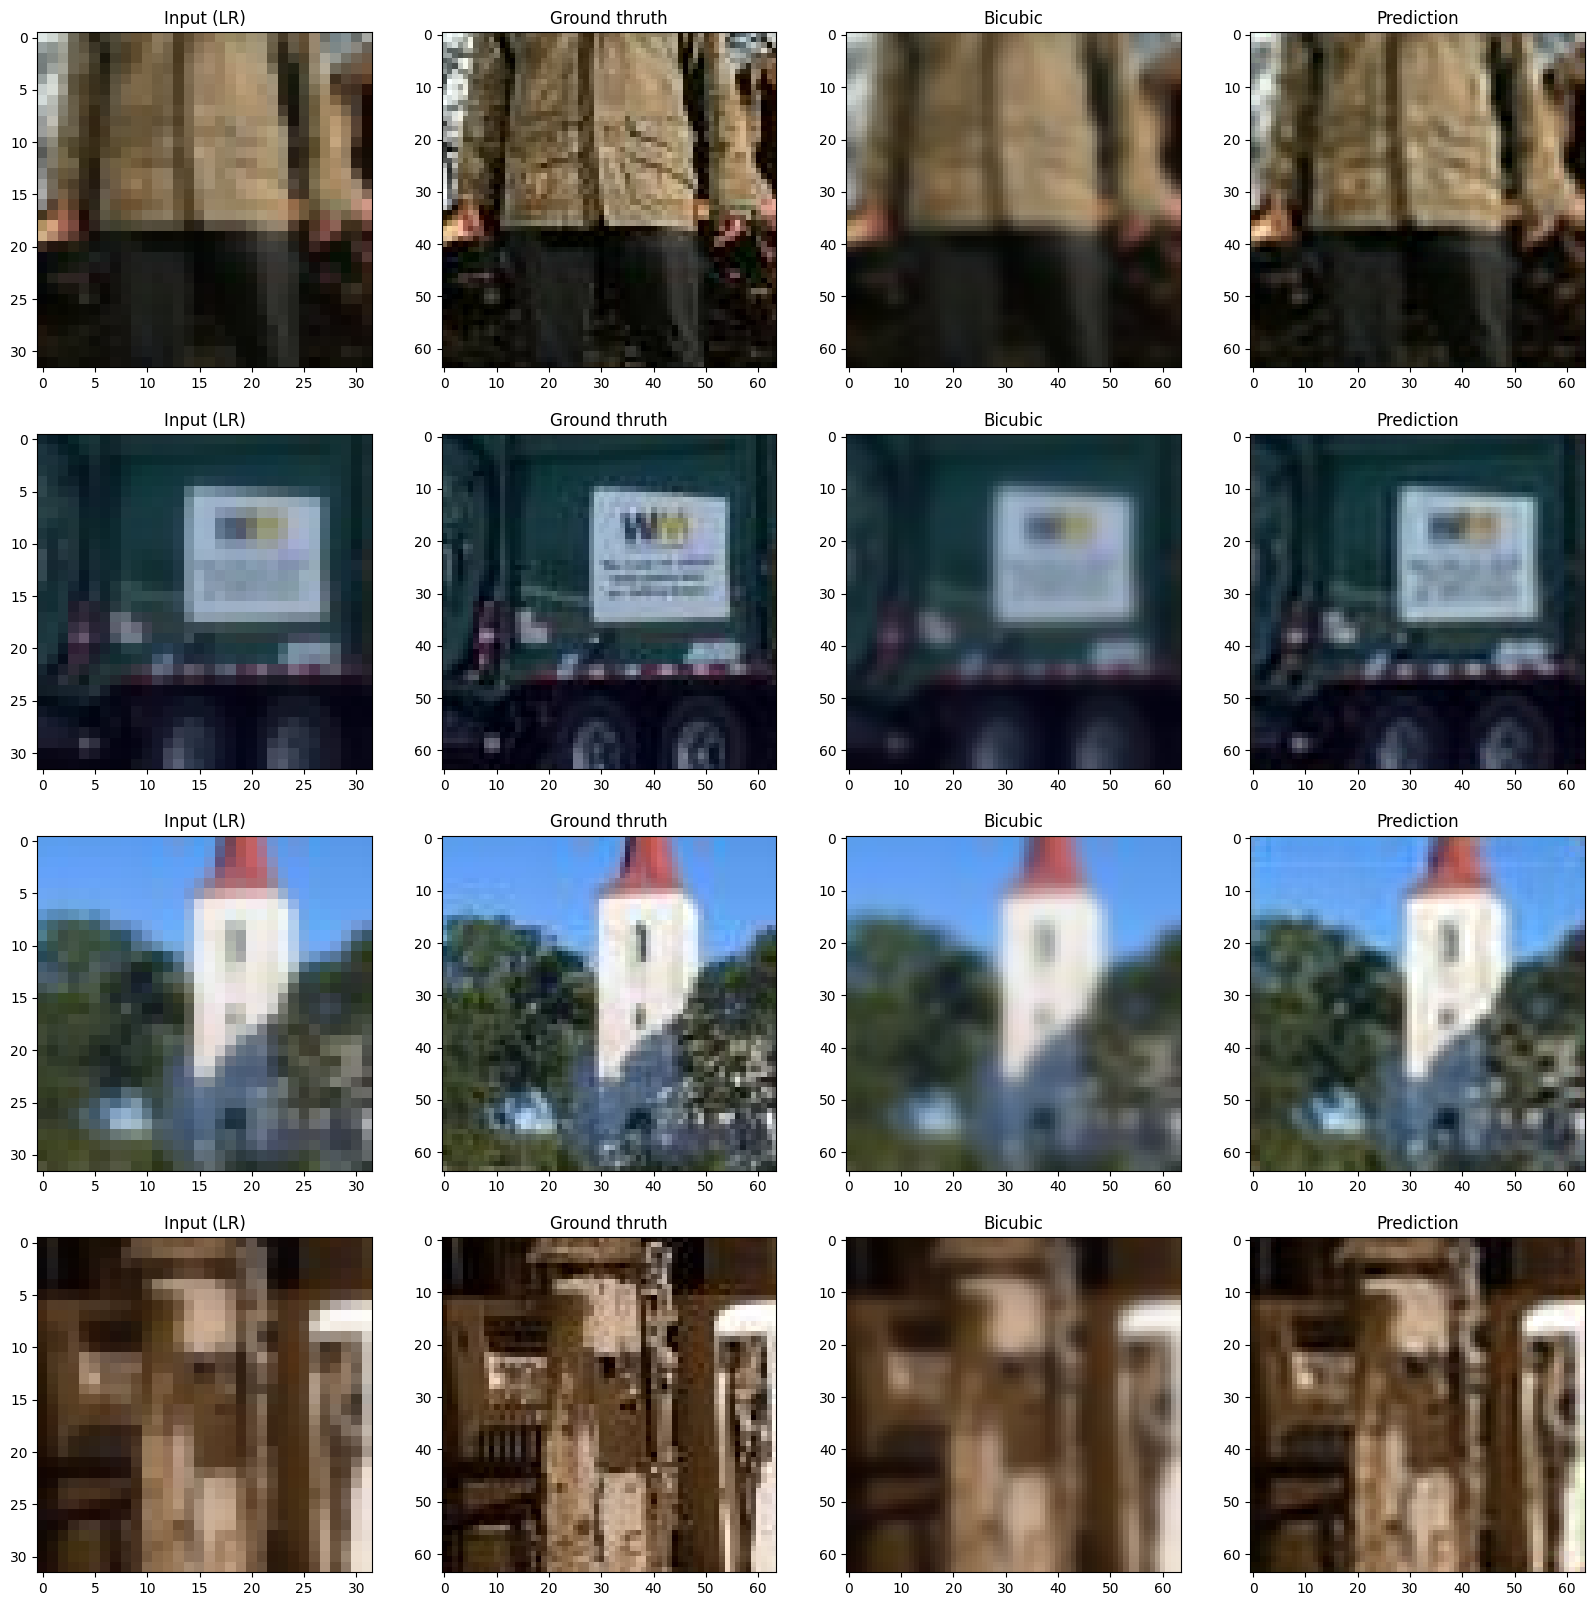

In [42]:
examples_count = 4

plt.figure(figsize=(20, 5 * examples_count))

for i in range(examples_count):
  input, output = lr_dataset_test[i]
  output_pred = lr_model(input.unsqueeze(0).to(device))

  plt.subplot(examples_count, 4, 4 * i + 1)
  plt.title('Input (LR)')
  plt.imshow(input.permute(1, 2, 0))

  plt.subplot(examples_count, 4, 4 * i + 2)
  plt.title('Ground thruth')
  plt.imshow(output.permute(1, 2, 0))

  plt.subplot(examples_count, 4, 4 * i + 3)
  plt.title('Bicubic')
  resized_input = v2.Resize(OUTPUT_SIZE)(input)
  plt.imshow(resized_input.permute(1, 2, 0))

  plt.subplot(examples_count, 4, 4 * i + 4)
  plt.title('Prediction')
  plt.imshow(output_pred.detach().cpu().squeeze(0).permute(1, 2, 0))
plt.show()